In [4]:
### install pyparsing==2.4.7 with sudo
import importlib
import blimpy
import h5py
import tensorflow as tf
import os
import re
import h5py
import numpy as np
import models
import utils
importlib.reload(models)
importlib.reload(utils)
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
import scipy.stats as stats
import sklearn
%load_ext autoreload
%autoreload 2

2022-12-16 10:18:18.754248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 10:18:19.591792: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-16 10:18:19.591884: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-16 10:18:23.382139: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

## Machine-Learning
We decided to take 3 different approaches to this problem.

### Convolutional Neural Network

In [ ]:
train_generator, validation_generator, test_generator = utils.get_generators("data")

convolution_layers = [
    tf.keras.layers.Conv2D(filters=224, kernel_size=11, activation='relu', input_shape=(200, 200, 3))
    ,tf.keras.layers.MaxPooling2D(2, 2),# The second convolution
    tf.keras.layers.Conv2D(filters=55, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),# The third convolution
    tf.keras.layers.Conv2D(filters=27, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),# The fourth convolution
    tf.keras.layers.Conv2D(filters=13, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),# # The fifth convolution
    tf.keras.layers.Conv2D(filters=13, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
]

dense_layers = [
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.5)
]

%matplotlib inline
cnn_model = models.CNN(convolution_layers, dense_layers, tf.keras.optimizers.Adam(), 10, 8, 5)
%time utils.train_eval(cnn_model, train_generator, validation_generator, test_generator)

In [20]:
cnn_model._model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 190, 190, 224)     81536     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 95, 95, 224)      0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 91, 91, 55)        308055    
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 45, 45, 55)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 43, 43, 27)        13392     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 21, 21, 27)      

### Setting up h5 data

For our previous example, we used images as our input data. For our future methods, we will need set up our X_train appropriaretly. 

In [5]:
# TRy making size of array and using indexing 
data = np.zeros((len(os.listdir("data/training/interesting_h5/")) + len(os.listdir("data/training/uninteresting_h5/")), 1025))
data = utils.gather_files("data/training/interesting_h5/", "average", data, 1, 0)
data = utils.gather_files("data/training/uninteresting_h5/", "average", data, 0, len(os.listdir("data/training/interesting_h5/")))

In [6]:
ds_train = data
# np.random.shuffle(ds_train)

In [7]:
# TRy making size of array and using indexing 
data = np.zeros((len(os.listdir("data/validation/interesting_h5/")) + len(os.listdir("data/validation/uninteresting_h5/")), 1025))
data = utils.gather_files("data/validation/interesting_h5/", "average", data, 1, 0)
data = utils.gather_files("data/validation/uninteresting_h5/", "average", data, 0, len(os.listdir("data/validation/interesting_h5/")))

In [8]:
ds_val = data
np.random.shuffle(ds_val)

In [9]:
# TRy making size of array and using indexing 
data = np.zeros((len(os.listdir("data/test/interesting_h5/")) + len(os.listdir("data/test/uninteresting_h5/")), 1025))
data = utils.gather_files("data/test/interesting_h5/", "average", data, 1, 0)
data = utils.gather_files("data/test/uninteresting_h5/", "average", data, 0, len(os.listdir("data/test/interesting_h5/")))

In [10]:
ds_test = data
np.random.shuffle(ds_test)

## Supervised Learning

In [13]:
from sklearn.model_selection import GridSearchCV
paramaters = {"criterion": ('gini', 'entropy', 'log_loss'), "max_features":[1,5], "max_depth":[4,16], "n_estimators": [75,125]}
clf = GridSearchCV(RandomForestClassifier(), paramaters)
clf.fit(ds_val[:,0:-2], ds_val[:,-1])
print(clf.best_params_)


/home/acoleman/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/acoleman/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/acoleman/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/acoleman/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/hom

{'criterion': 'entropy', 'max_depth': 16, 'max_features': 5, 'n_estimators': 125}


              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1751
           1       0.55      0.74      0.63       351

    accuracy                           0.86      2102
   macro avg       0.75      0.81      0.77      2102
weighted avg       0.88      0.86      0.86      2102

CPU times: user 8.11 s, sys: 0 ns, total: 8.11 s
Wall time: 8.12 s


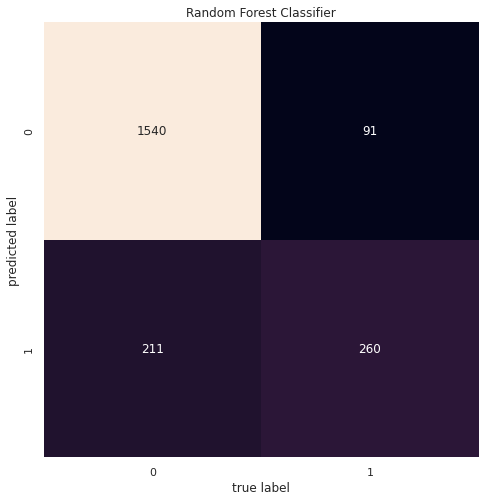

In [16]:
%matplotlib inline
random_forest_model = models.RF("entropy", 125, 16, 5)
%time utils.train_eval(random_forest_model, ds_train, ds_val, ds_test)

## Anomoly Detection

### Isolation Forest

#### Contamination = 0.1

In [18]:
print(ds_train.shape)
contam_1 = ds_train[4500:-1, :]
isolation_forest_model = models.IF(10, 75, 0.1, False)
%time utils.train_eval(isolation_forest_model, contam_1, ds_val, ds_test)

(2002, 1025)


ValueError: Found array with 0 sample(s) (shape=(0, 1023)) while a minimum of 1 is required.

#### Contamination = 0.5

In [19]:
from sklearn.metrics import make_scorer, f1_score
paramaters = {"max_samples": [1, 10], "bootstrap": (True, False),"n_estimators": [75,125], "contamination":[0.5]}
f1sc = make_scorer(f1_score, average='micro')
clf = GridSearchCV(IsolationForest(), paramaters, scoring=f1sc, refit=True)
g = lambda x: -1 if x == 1 else 0
y = list(map(g, ds_val[:, -1]))
clf.fit(ds_val[:,0:-2], y)
print(clf.best_params_)

{'bootstrap': True, 'contamination': 0.5, 'max_samples': 10, 'n_estimators': 125}


              precision    recall  f1-score   support

           0       0.83      0.52      0.64      1751
           1       0.17      0.48      0.25       351

    accuracy                           0.51      2102
   macro avg       0.50      0.50      0.44      2102
weighted avg       0.72      0.51      0.57      2102

CPU times: user 13.4 s, sys: 0 ns, total: 13.4 s
Wall time: 13.4 s


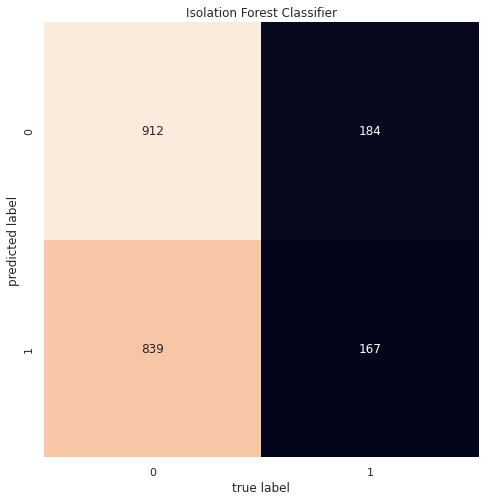

In [20]:
isolation_forest_model = models.IF(10, 75, 0.5, False)
%time utils.train_eval(isolation_forest_model, ds_train, ds_val, ds_test)

              precision    recall  f1-score   support

           0       0.85      0.55      0.67      1751
           1       0.18      0.50      0.27       351

    accuracy                           0.54      2102
   macro avg       0.52      0.53      0.47      2102
weighted avg       0.74      0.54      0.60      2102

CPU times: user 2.52 s, sys: 0 ns, total: 2.52 s
Wall time: 2.52 s


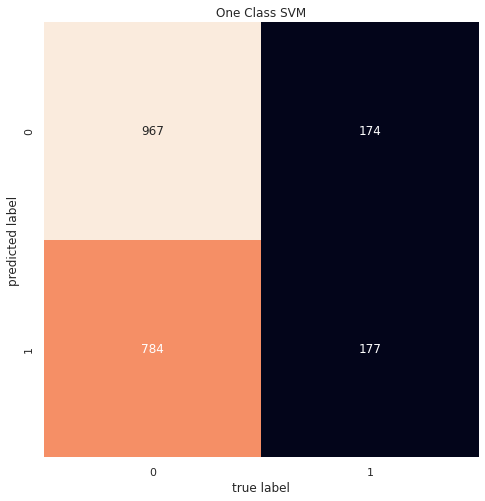

In [22]:
one_class_svm_model = models.OCSVM(kernel='rbf',gamma="scale",tol=1e-3)
%time utils.train_eval(one_class_svm_model, ds_train, ds_val, ds_test)

## Attempt 2

### Setting up the .h5 data

In [23]:
# TRy making size of array and using indexing 
data = np.zeros((len(os.listdir("data_2/training/interesting_h5/")) + len(os.listdir("data_2/training/uninteresting_h5/")), 1025))
data = utils.gather_files("data_2/training/interesting_h5/", "average", data, 1, 0)
data = utils.gather_files("data_2/training/uninteresting_h5/", "average", data, 0, len(os.listdir("data_2/training/interesting_h5/")))

In [24]:
ds_train_2 = data

In [25]:
# TRy making size of array and using indexing 
data = np.zeros((len(os.listdir("data_2/validation/interesting_h5/")) + len(os.listdir("data_2/validation/uninteresting_h5/")), 1025))
data = utils.gather_files("data_2/validation/interesting_h5/", "average", data, 1, 0)
data = utils.gather_files("data_2/validation/uninteresting_h5/", "average", data, 0, len(os.listdir("data_2/validation/interesting_h5/")))

In [26]:
ds_val_2 = data
np.random.shuffle(ds_val_2)

In [27]:
# TRy making size of array and using indexing 
data = np.zeros((len(os.listdir("data_2/test/interesting_h5/")) + len(os.listdir("data_2/test/uninteresting_h5/")), 1025))
data = utils.gather_files("data_2/test/interesting_h5/", "average", data, 1, 0)
data = utils.gather_files("data_2/test/uninteresting_h5/", "average", data, 0, len(os.listdir("data_2/test/interesting_h5/")))

In [28]:
ds_test_2 = data
np.random.shuffle(ds_test_2)

### Supervised Learning

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1750
           1       0.85      0.96      0.90       250

    accuracy                           0.97      2000
   macro avg       0.92      0.97      0.94      2000
weighted avg       0.98      0.97      0.97      2000

CPU times: user 1.26 s, sys: 0 ns, total: 1.26 s
Wall time: 1.32 s


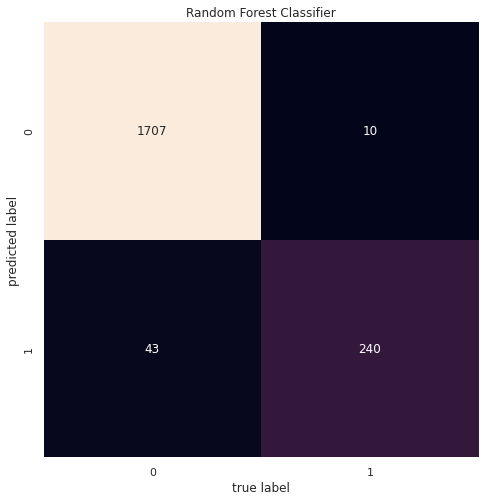

In [63]:
%matplotlib inline
random_forest_model_2 = models.RF("entropy", 125, 16, 5)
%time utils.train_eval(random_forest_model_2, ds_train_2, ds_val_2, ds_test_2)

### Anomaly detection

#### Contamination = 0.5

              precision    recall  f1-score   support

           0       0.87      0.49      0.63      1750
           1       0.12      0.49      0.20       250

    accuracy                           0.49      2000
   macro avg       0.50      0.49      0.41      2000
weighted avg       0.78      0.49      0.58      2000

CPU times: user 2.28 s, sys: 0 ns, total: 2.28 s
Wall time: 2.28 s


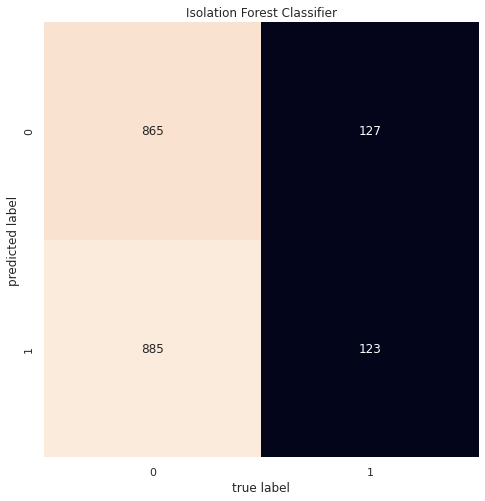

In [64]:
isolation_forest_50_model_2 = models.IF(10, 75, 0.5, False)
%time utils.train_eval(isolation_forest_50_model_2, ds_train_2, ds_val_2, ds_test_2)

#### Contamination = 0.1

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      1750
           1       0.12      0.10      0.11       250

    accuracy                           0.80      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.78      0.80      0.79      2000

CPU times: user 1.04 s, sys: 0 ns, total: 1.04 s
Wall time: 1.04 s


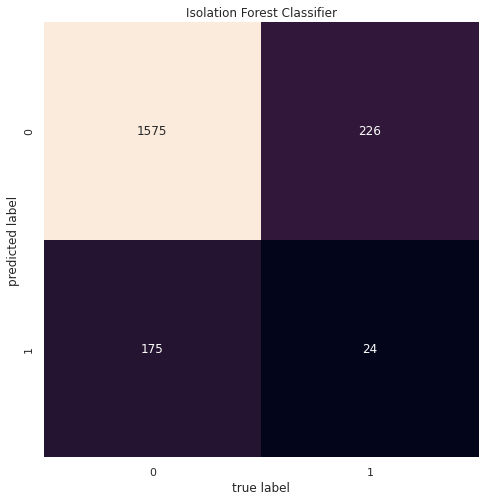

In [66]:
temp_ds_train_2 = ds_train_2[900:-1,:]
isolation_forest_10_model_2 = models.IF(10, 75, 0.1, False)
%time utils.train_eval(isolation_forest_10_model_2, temp_ds_train_2, ds_val_2, ds_test_2)

              precision    recall  f1-score   support

           0       0.90      0.55      0.68      1750
           1       0.15      0.55      0.23       250

    accuracy                           0.55      2000
   macro avg       0.52      0.55      0.46      2000
weighted avg       0.80      0.55      0.63      2000

CPU times: user 2.53 s, sys: 0 ns, total: 2.53 s
Wall time: 2.54 s


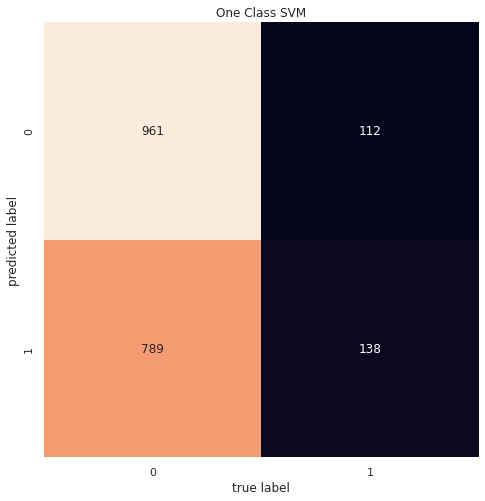

In [67]:
one_class_svm_model_2 = models.OCSVM(kernel='rbf',gamma="scale",tol=1e-3)
%time utils.train_eval(one_class_svm_model_2, ds_train_2, ds_val_2, ds_test_2)

### CNN

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/10
8/8 [==============================] - 34s 4s/step - loss: 0.7495 - accuracy: 0.5625 - val_loss: 0.7071 - val_accuracy: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 31s 4s/step - loss: 0.6950 - accuracy: 0.4583 - val_loss: 0.6518 - val_accuracy: 1.0000
Epoch 3/10
8/8 [==============================] - 32s 4s/step - loss: 0.6877 - accuracy: 0.5543 - val_loss: 0.6610 - val_accuracy: 0.9000
Epoch 4/10
8/8 [==============================] - 27s 3s/step - loss: 0.6442 - accuracy: 0.6458 - val_loss: 0.8141 - val_accuracy: 0.3000
Epoch 5/10
8/8 [==============================] - 26s 3s/step - loss: 0.4186 - accuracy: 0.8587 - val_loss: 0.1491 - val_accuracy: 0.9250
Epoch 6/10
8/8 [==============================] - 25s 3s/step - loss: 0.1193 - accuracy: 0.9688 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 7/10
8/8 [==========================

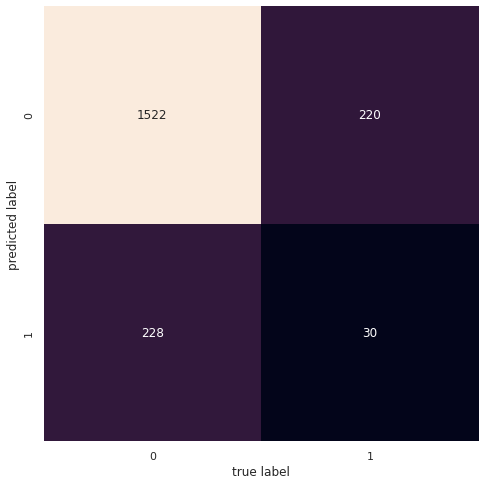

In [42]:
train_generator, validation_generator, test_generator = utils.get_generators("data_2")

convolution_layers = [
    tf.keras.layers.Conv2D(filters=224, kernel_size=11, activation='relu', input_shape=(200, 200, 3))
    ,tf.keras.layers.MaxPooling2D(2, 2),# The second convolution
    tf.keras.layers.Conv2D(filters=55, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),# The third convolution
    tf.keras.layers.Conv2D(filters=27, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),# The fourth convolution
    tf.keras.layers.Conv2D(filters=13, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),# # The fifth convolution
    tf.keras.layers.Conv2D(filters=13, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
]

dense_layers = [
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.5)
]

%matplotlib inline
cnn_model = models.CNN(convolution_layers, dense_layers, tf.keras.optimizers.Adam(), 10, 8, 5)
%time utils.train_eval(cnn_model, train_generator, validation_generator, test_generator)

## Attempt 3

### Setting up .h5 files

In [34]:
data = np.zeros((len(os.listdir("data_2/training/interesting_h5/")) + len(os.listdir("data_2/training/uninteresting_h5/")), 1025))
data = utils.gather_off_files("data_2/training/interesting_h5/", "average", data, 1, 0)
data = utils.gather_off_files("data_2/training/uninteresting_h5/", "average", data, 0, len(os.listdir("data_2/training/interesting_h5/")))

In [35]:
ds_train_3 = data

In [36]:
data = np.zeros((len(os.listdir("data_2/test/interesting_h5/")) + len(os.listdir("data_2/test/uninteresting_h5/")), 1025))
data = utils.gather_off_files("data_2/test/interesting_h5/", "average", data, 1, 0)
data = utils.gather_off_files("data_2/test/uninteresting_h5/", "average", data, 0, len(os.listdir("data_2/test/interesting_h5/")))

In [37]:
ds_test_3 = data
np.random.shuffle(ds_test_3)

## Supervised Learning

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1750
           1       0.64      1.00      0.78       250

    accuracy                           0.93      2000
   macro avg       0.82      0.96      0.87      2000
weighted avg       0.95      0.93      0.94      2000

CPU times: user 1.06 s, sys: 0 ns, total: 1.06 s
Wall time: 1.06 s


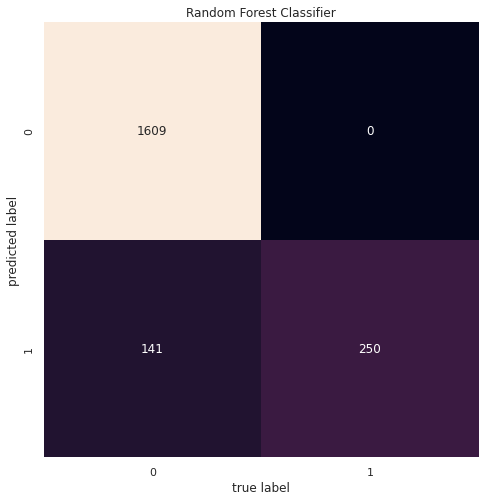

In [83]:
%matplotlib inline
random_forest_model_3 = models.RF("entropy", 125, 16, 5)
%time utils.train_eval(random_forest_model_3, ds_train_3, ds_train_3, ds_test_3)

## Anomaly Detection

### Contamination = 0.5

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1750
           1       0.51      0.88      0.65       250

    accuracy                           0.88      2000
   macro avg       0.75      0.88      0.79      2000
weighted avg       0.92      0.88      0.89      2000

CPU times: user 2.2 s, sys: 0 ns, total: 2.2 s
Wall time: 2.21 s


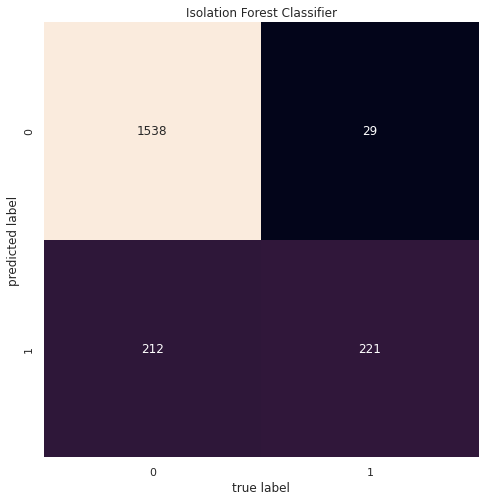

In [84]:
isolation_forest_50_model_3 = models.IF(10, 75, 0.5, False, "flip")
%time utils.train_eval(isolation_forest_50_model_3, ds_train_3, ds_train_3, ds_test_3)

### Contamination = 0.1

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1750
           1       0.00      0.00      0.00       250

    accuracy                           0.88      2000
   macro avg       0.44      0.50      0.47      2000
weighted avg       0.77      0.88      0.82      2000

CPU times: user 1.51 s, sys: 0 ns, total: 1.51 s
Wall time: 1.9 s


/home/acoleman/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/acoleman/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/acoleman/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


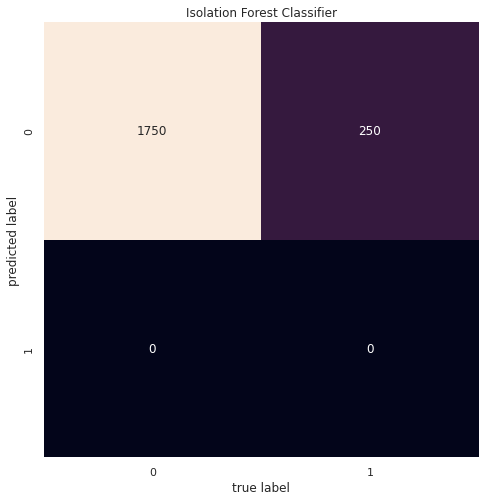

In [80]:
temp_ds_train_3 = ds_train_2[900:-1,:]
isolation_forest_10_model_3 = models.IF(10, 75, 0.1, False, "flip")
%time utils.train_eval(isolation_forest_10_model_3, temp_ds_train_3, ds_train_3, ds_test_3)

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1750
           1       0.36      0.83      0.50       250

    accuracy                           0.79      2000
   macro avg       0.67      0.81      0.69      2000
weighted avg       0.89      0.79      0.82      2000

CPU times: user 2.9 s, sys: 0 ns, total: 2.9 s
Wall time: 2.89 s


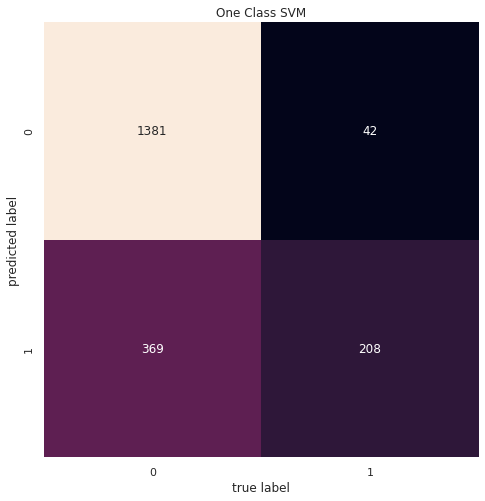

In [81]:
one_class_svm_model_3 = models.OCSVM(kernel='rbf',gamma="scale",tol=1e-3, mode="flip")
%time utils.train_eval(one_class_svm_model_3, ds_train_3, ds_train_3, ds_test_3)

## Statistical Methods

In [49]:
accuracies = {
"random_forest": {},
"isolation_forest":{},
"one_class_svm":{}
}

In [50]:
batch_size = 100

In [57]:
accuracies["random_forest"]["attempt_1"] = []
accuracies["isolation_forest"]["attempt_1"] = []
accuracies["one_class_svm"]["attempt_1"] = []
for i in range(0, len(ds_test), batch_size):
    temp = ds_test[i:i+batch_size,:]
    predicted = random_forest_model.predict(temp)
    y_test = temp[:,-1]
    accuracies["random_forest"]["attempt_1"].append(sklearn.metrics.mean_squared_error(y_test, predicted))
    predicted = isolation_forest_model.predict(temp)
    accuracies["isolation_forest"]["attempt_1"].append(sklearn.metrics.mean_squared_error(y_test, predicted))
    predicted = one_class_svm_model.predict(temp)
    accuracies["one_class_svm"]["attempt_1"].append(sklearn.metrics.mean_squared_error(y_test, predicted))
    
    

In [58]:
accuracies["random_forest"]["attempt_1"]

[0.84,
 0.8,
 0.8,
 0.85,
 0.86,
 0.89,
 0.85,
 0.81,
 0.84,
 0.78,
 0.89,
 0.84,
 0.85,
 0.84,
 0.81,
 0.88,
 0.94,
 0.9,
 0.84,
 0.81,
 0.82,
 1.0]

In [59]:
print(accuracies["isolation_forest"]["attempt_1"])

[0.66, 0.66, 0.77, 0.72, 0.76, 0.71, 0.67, 0.67, 0.75, 0.66, 0.66, 0.72, 0.72, 0.68, 0.63, 0.69, 0.74, 0.73, 0.74, 0.69, 0.68, 0.5]


In [60]:
stats.ttest_ind(accuracies["random_forest"]["attempt_1"] , accuracies["isolation_forest"]["attempt_1"])

Ttest_indResult(statistic=9.866466424403415, pvalue=1.6735122203162104e-12)

In [61]:
stats.ttest_ind(accuracies["random_forest"]["attempt_1"] , accuracies["one_class_svm"]["attempt_1"])

Ttest_indResult(statistic=0.7417851792598296, pvalue=0.4623455955371414)

In [68]:
accuracies["random_forest"]["attempt_2"] = []
accuracies["isolation_forest"]["attempt_2"] = []
accuracies["one_class_svm"]["attempt_2"] = []
for i in range(0, len(ds_test_2), batch_size):
    temp = ds_test_2[i:i+batch_size,:]
    predicted = random_forest_model_2.predict(temp)
    y_test = temp[:,-1]
    accuracies["random_forest"]["attempt_2"].append(sklearn.metrics.mean_squared_error(y_test, predicted))
    predicted = isolation_forest_10_model_2.predict(temp)
    accuracies["isolation_forest"]["attempt_2"].append(sklearn.metrics.mean_squared_error(y_test, predicted))
    predicted = one_class_svm_model_2.predict(temp)
    accuracies["one_class_svm"]["attempt_2"].append(sklearn.metrics.mean_squared_error(y_test, predicted))
    
    

In [69]:
stats.ttest_ind(accuracies["random_forest"]["attempt_2"] , accuracies["one_class_svm"]["attempt_2"])

Ttest_indResult(statistic=-30.271492301231657, pvalue=3.302883082740973e-28)

In [70]:
stats.ttest_ind(accuracies["random_forest"]["attempt_2"] , accuracies["isolation_forest"]["attempt_2"])

Ttest_indResult(statistic=-19.15676951319867, pvalue=4.0186738162700735e-21)

In [97]:
accuracies["random_forest"]["attempt_3"] = []
accuracies["isolation_forest"]["attempt_3"] = []
accuracies["one_class_svm"]["attempt_3"] = []
for i in range(0, len(ds_test_3), batch_size):
    temp = ds_test_2[i:i+batch_size,:]
    predicted = random_forest_model_3.predict(temp)
    y_test = temp[:,-1]
    accuracies["random_forest"]["attempt_3"].append(sklearn.metrics.mean_squared_error(y_test, predicted))
    predicted = isolation_forest_10_model_3.predict(temp)
    accuracies["isolation_forest"]["attempt_3"].append(sklearn.metrics.mean_squared_error(y_test, predicted))
    predicted = one_class_svm_model_3.predict(temp)
    accuracies["one_class_svm"]["attempt_3"].append(sklearn.metrics.mean_squared_error(y_test, predicted))
    
    

In [98]:
stats.ttest_ind(accuracies["random_forest"]["attempt_3"] , accuracies["one_class_svm"]["attempt_3"])

Ttest_indResult(statistic=71.23654327528988, pvalue=4.595694626027871e-42)

In [99]:
stats.ttest_ind(accuracies["random_forest"]["attempt_3"] , accuracies["isolation_forest"]["attempt_3"])

Ttest_indResult(statistic=6.274555350225965, pvalue=2.3930942739838313e-07)